In [1]:
# Initialise a spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("Plotter")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

24/10/01 17:11:21 WARN Utils: Your hostname, DESKTOP-0EEO7M5 resolves to a loopback address: 127.0.1.1; using 172.30.68.91 instead (on interface eth0)
24/10/01 17:11:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 17:11:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import polars as pl 
import pyarrow as pa 

In [3]:
import matplotlib.pyplot as plt 

# Figure 1: outlier detection 

In [3]:
imputed = spark.read.parquet('../data/curated/imputed_data')

In [11]:
# Take a sample for plotting
sample_fraction = 0.2
sampled_data = imputed.sample(withReplacement=False, fraction=sample_fraction, seed=42)

df = pl.from_arrow(pa.Table.from_batches(sampled_data.select("dollar_value", "z_score")._collect_as_arrow()))

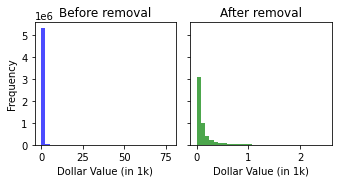

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True)
plt.sca(ax1)
plt.hist(df['dollar_value']/1e3, bins=30, color='blue', alpha=0.7)
plt.title('Before removal')
plt.xlabel('Dollar Value (in 1k)')
plt.ylabel('Frequency')


plt.sca(ax2)
plt.hist(df.filter(pl.col('z_score').abs() <=3)['dollar_value']/1e3, bins=30, color='green', alpha=0.7)
plt.title('After removal')
plt.xlabel('Dollar Value (in 1k)')

fig.subplots_adjust(wspace=.1, bottom=.2, right=.95)
plt.savefig('../plots/outlier_removal.png', dpi=300)

# Figure 2: Flagging fraud 

In [4]:
transactions = spark.read.parquet('../data/curated/aggregated_data')

Convert into Polars Dataframe.

In [8]:
df = pl.from_arrow(pa.Table.from_batches(
    transactions
    .sample(withReplacement=False, fraction=0.2, seed=42)
    .select(
    "dollar_value", "fraud_probability_consumer", "fraud_probability_merchant",
    "user_id", "order_datetime", "merchant_abn", 
)._collect_as_arrow()))

In [21]:
consumer_weekly = df.lazy().group_by(
    "user_id", 
    pl.col('order_datetime').str.to_date().dt.week().alias('week'), 
    pl.col('order_datetime').str.to_date().dt.year().alias('year'),
).len().select(
    pl.col('len').alias('consumer_weekly_transaction')
).collect()

In [23]:
merchant_weekly = df.lazy().group_by(
    "merchant_abn", 
    pl.col('order_datetime').str.to_date().dt.week().alias('week'), 
    pl.col('order_datetime').str.to_date().dt.year().alias('year'),
).len().select(
    pl.col('len').alias('merchant_weekly_transaction')
).collect()

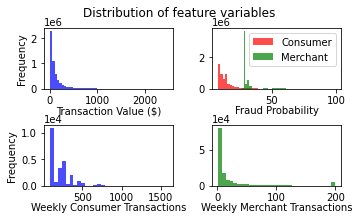

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 3))
plt.sca(ax1)
plt.hist(df['dollar_value'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Transaction Value ($)', labelpad=0)
plt.ylabel('Frequency')

plt.sca(ax2)
plt.hist(df['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer")
plt.hist(df['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant")
plt.xlabel('Fraud Probability', labelpad=0)
plt.legend()


plt.sca(ax3)
plt.hist(consumer_weekly["consumer_weekly_transaction"], bins=30, color="blue", alpha=0.7)
plt.xlabel("Weekly Consumer Transactions", labelpad=0)
plt.ylabel('Frequency')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


plt.sca(ax4)
plt.hist(merchant_weekly["merchant_weekly_transaction"].clip(upper_bound=200), bins=30, color="green", alpha=0.7)
plt.xlabel("Weekly Merchant Transactions", labelpad=0)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.suptitle('Distribution of feature variables')

fig.subplots_adjust(hspace=.6, bottom=.15, wspace=.3, right=.95)
plt.savefig('../plots/distributions.png', dpi=300)